<a href="https://colab.research.google.com/github/AndySAnker/ML-MotEx/blob/main/ML_MotEx_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Welcome to ML-MotEx </center></h1>

**Github:** https://github.com/AndySAnker/ML-MotEx

**Paper:** Extracting Structural Motifs from Pair Distribution Function Data of Nanostructures using Explainable Machine Learning

**Questions:** andy@chem.ku.dk

Use this script to use ML-MotEx to extract a structural motif from a dataset. This script does only handle Pair Distribution Function (PDF) data but ML-MotEx can in principle handle any data.

If you have already fitted the dataset with multiple structures or you have have another type of data than PDF please go on to step 3 halfway through the script.

# First install python packages

In [ ]:
%%capture
!pip install ase shap xgboost bayesian-optimization
!git clone https://github.com/AndySAnker/ML-MotEx.git

# First download Anaconda

In [ ]:
%%capture
%%bash 
MINICONDA_INSTALLER_SCRIPT=Miniconda3-latest-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX


# Download DiffPy-CMI

In [ ]:
%%capture
!conda create -n diffpy -c defaults -c diffpy python=3.7 diffpy-cmi pandas --yes
!cp -r /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/* /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy/
!cp -r /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.structure-3.0.1-py3.7.egg/diffpy/* /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy/
!cp -r /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.utils-3.0.0-py3.7.egg/diffpy/* /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy/

import sys
sys.path.insert(1, "/usr/local/envs/diffpy/lib/python3.7/site-packages")

# import modules, set seed parameters and import functions

In [ ]:
%%capture
import numpy as np
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import time, random, shap
from scipy.optimize.minpack import leastsq
from diffpy.Structure import Structure, Atom
from diffpy.srfit.pdf import PDFContribution, PDFParser, PDFGenerator
from diffpy.srfit.fitbase import FitRecipe, FitResults, Profile, FitContribution
from diffpy.srreal.pdfcalculator import DebyePDFCalculator
from multiprocessing import Pool
from functools import partial
from ase.io import read
from google.colab import output, files
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import pandas as pd

random.seed(14)
np.random.seed(14)

In [ ]:
def Load_starting_model(starting_model):
    """This function loads the structure"""

    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    struct=[]
    with open(starting_model, 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            if len(sep_line)==4: #  tillader andre informationer i xyz filen some ikke skal laeses
                struct.append(sep_line)
    elements=np.array(struct)[:,0]
    xyz=(np.array(struct)[:,1:].astype(float))
    
    return elements, xyz

def structure_catalogue_maker(Number_of_structures, Number_of_atoms, lower_atom_number, higher_atom_number):
    """This function makes a shuffled list containing 'Number_of_structures' number of lists which each is 
    'Number_of_atoms' long and is randomly distributed with 0's and 1's whereas the minimum number of 1's are 
    'lower_atom_number' and the maximum number of 1's are 'higher_atom_number'."""
    
    print ("Starting to make a structure catalogue with: ", str(Number_of_structures) + " structure from the starting model.")
    print ("The structure will have between " + str(lower_atom_number) + " and " + str(higher_atom_number) + " atoms")
    structure_catalogue = []
    for i in range(Number_of_structures):
        one_count = random.randint(lower_atom_number, higher_atom_number)
        zero_count = Number_of_atoms  - one_count
        my_list = [0]*zero_count + [1]*one_count
        random.shuffle(my_list)
        my_list.insert(0, one_count)
        structure_catalogue.append(my_list)
    print ("Permutations Succeeded")
    return structure_catalogue
    
def fitting(structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, plot, index):
    """This function takes in a 'starting_model', and an 'index' from the 'structure_catalogue'. It generates the 
    corresponding structure and fit it to the 'Experimental_Data'."""
    
    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    stru = read(starting_model)
    xyz = stru.get_positions()
    xyz_W = xyz[:NumW].copy()
    xyz_O = xyz[NumW:len(xyz)].copy()
    keep_O = np.zeros(len(xyz_O))
    h = 0
    # Cycle through W atoms and delete W according to index 0's from permutation
    permutations = np.asarray(structure_catalogue)[:,1:]
    for j in range(len(xyz_W)):
        if permutations[index][j] == 0:
            xyz_W = np.delete(xyz_W,j - h,0)
            h = h+1   
    # Cycle through all atoms that is not iteratable and test if it is within the threshold distance. Delete atoms with no bonds
    for j in range(len(xyz_O)):        
        for k in range(len(xyz_W)):
            dist = np.linalg.norm(xyz_W[k] - xyz_O[j])
            if dist < threshold:    
                keep_O[j] = 1
                break
    h = 0            
    for j in range(len(xyz_O)):
        if keep_O[j] == 0:
            xyz_O = np.delete(xyz_O,j - h, 0)
            h += 1
            
    # Create structure for iterable (W) and non-iterable (O) atoms and combine them
    W_cluster = Structure([Atom('W', xi) for xi in xyz_W])
    O_cluster = Structure([Atom('O', xi) for xi in xyz_O])
    cluster = W_cluster + O_cluster
    
    # Make a standard cluster refinement using Diffpy-CMI
    # Import the data and make it a PDFprofile. Define the range of the data that will be used in the fit.
    pdfprofile = Profile()
    pdfparser = PDFParser()
    pdfparser.parseFile(Experimental_Data)
    pdfprofile.loadParsedData(pdfparser)
    pdfprofile.setCalculationRange(xmin = rmin, xmax = rmax)

    # Setup the PDFgenerator that calculates the PDF from the structure
    pdfgenerator_cluster = PDFGenerator("G")
    # Add the profile and both generators to the PDFcontribution
    pdfcontribution = FitContribution("pdf")
    pdfcontribution.setProfile(pdfprofile, xname="r") 
    pdfcontribution.addProfileGenerator(pdfgenerator_cluster)
    
    pdfgenerator_cluster.setQmin(Qmin)
    pdfgenerator_cluster.setQmax(Qmax)
    pdfgenerator_cluster._calc.evaluatortype = 'OPTIMIZED'
    pdfgenerator_cluster.setStructure(cluster, periodic = False)

    # Use scaling factors proportional to molar content
    pdfcontribution.setEquation('mc*G')

    # Define the recipe to do the fit and add it to the PDFcontribution
    recipe = FitRecipe()
    recipe.addContribution(pdfcontribution)

    # Avoid too much output during fitting 
    recipe.clearFitHooks()

    # Add the scale factor.
    recipe.addVar(pdfcontribution.mc, 1.0, tag = "scale")
    
    # Add the instrumental parameters to the two generators
    pdfgenerator_cluster.qdamp.value = Qdamp
    
    # Add the delta2 parameters, and make sure it cannot take unphysical values
    recipe.addVar(pdfgenerator_cluster.delta2, 0, name = "delta2_cluster", tag = "delta2")

    # Add ADP and "cell" for the cluster
    phase_cluster = pdfgenerator_cluster.phase
    atoms = phase_cluster.getScatterers()
    lat = phase_cluster.getLattice()

    recipe.newVar("zoomscale1", 1.0, tag = "lat")
    recipe.newVar("zoomscale2", 1.0, tag = "lat")
    recipe.newVar("zoomscale3", 1.0, tag = "lat")
    recipe.constrain(lat.a, 'zoomscale1')
    recipe.constrain(lat.b, 'zoomscale2')
    recipe.constrain(lat.c, 'zoomscale3')

    W_cluster = recipe.newVar("W_Biso_cluster1", 0.4, tag = 'adp_w')
    O_cluster = recipe.newVar("O_Biso_cluster1", 0.4, tag = 'adp_o')

    for atom in atoms:
      if atom.element.title() == atom_ph:
            recipe.constrain(atom.Biso, W_cluster)
      elif atom.element.title() == "O":
            recipe.constrain(atom.Biso, O_cluster)

    recipe.restrain("zoomscale1", lb = 0.99, ub = 1.01, sig = 0.001)
    recipe.restrain("zoomscale2", lb = 0.99, ub = 1.01, sig = 0.001)
    recipe.restrain("zoomscale3", lb = 0.99, ub = 1.01, sig = 0.001)
    
    #free parameters are set
    recipe.fix('all')
    recipe.free("scale", "lat")

    # Turn off printout of iteration number.
    #recipe.clearFitHooks()

    # We can now execute the fit using scipy's least square optimizer.
    leastsq(recipe.residual, recipe.getValues())
    
    # We calculate the goodness-of-fit, Rwp
    g = recipe.pdf.profile.y
    gcalc = recipe.pdf.evaluate()
    rfactor1 = np.sqrt(sum((g - gcalc)**2) / sum((g)**2))
    
    # if plot == 1 it will also plot the fit
    if plot == 1:
        print ("FIT RESULTS\n")
        res1 = FitResults(recipe)
        print (res1)

        # Plot the observed and refined PDF.
        # Get the experimental data from the recipe
        r = recipe.pdf.profile.x
        gobs = recipe.pdf.profile.y

        # Get the calculated PDF and compute the difference between the calculated and measured PDF
        gcalc = recipe.pdf.evaluate()
        baseline = 1.1 * gobs.min()
        gdiff = gobs - gcalc

        # Plot!
        plt.figure()
        plt.plot(r, gobs, 'bo', label="G(r) data")
        plt.plot(r, gcalc, 'r-', label="G(r) fit")
        plt.plot(r, gdiff + baseline, 'g-', label="G(r) diff")
        plt.plot(r, np.zeros_like(r) + baseline, 'k:')
        plt.xlabel(r"$r (\AA)$")
        plt.ylabel(r"$G (\AA^{-2})$")
        plt.legend()

        plt.show()
    return rfactor1

def fitting_multiprocess(structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, SaveName, cores=1):
    """This function runs the refinement of all the structures in the structure catalogue using multiprocessing"""
    start_time = time.time()
    values = []
    # Set up multiprocessing refinement
    fitindex = range(len(structure_catalogue))
    p = Pool(processes=cores)
    plot = 0
    func = partial(fitting, structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, plot)
    results = p.map(func, fitindex)
    p.close()
    p.join()
    
    # Start refinement and append results to lists
    for i in fitindex:
        if i % 100 == 0:
            print ("I have now fitted: ", str(i) + " structures out of " + str(len(structure_catalogue)))
        rw = results[i]
        values.append(i)
        values.append(rw)
    values = np.reshape(values,(int(len(values)/2) , 2))
    
    # Save results in format that is suitable for Machine Learning
    print ("Best fit")
    print (values[np.argmin(values[:,1])])
    print("Total execution time: %.3fs" % (time.time()-start_time))
    Result = np.column_stack([values, np.asarray(structure_catalogue)[values[:,0].astype(int)]])
    np.savetxt(SaveName, Result)
    return Result

def Import_Dataset(FileName):
    """This function loads a catalogue of structures with their corresponding Rwp values and split the dataset 
    into a training set and validation set with features and labels."""
    # load data
    dataset = np.loadtxt(FileName, delimiter=" ", skiprows=0)
    dataset_original = dataset.copy()

    # Split into training and validation set
    dataset_train = dataset[:int(len(dataset)*0.8)]
    dataset_val = dataset[int(len(dataset)*0.8):len(dataset)]
    
    # split data into features (X) and labels (y)
    X_train = dataset_train[:,2:len(dataset)+1]
    y_train = dataset_train[:,1]
    X_val = dataset_val[:,2:len(dataset)+1]
    y_val = dataset_val[:,1]
    
    print("Number of Training Data:", len(y_train))
    print("Number of Validation Data:", len(y_val))
        
    return X_train, y_train, X_val, y_val
    
def Validate_XGBoost(model, X_val, y_val):
    """Function to validate the performance of the XGBoost algorithm on a validation set"""
    print ("Giving an estimate of the accuracy of the model")
    xgb_val = xgb.DMatrix(X_val, y_val)
    y_pred_val = model.predict(xgb_val)
    rmse = mean_squared_error(y_val, y_pred_val)
    print("RMSE: %f" % (rmse))
    return rmse

def DecisionTree_CrossValidation(learning_rate, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=0, 
                                       learning_rate = learning_rate,
                                       max_depth=max_depth,
                                       objective='reg:squarederror') 
    
    cval = cross_val_score(estimator, data, targets, cv=3)
    return cval.mean()

def optimize_DecisionTree(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(learning_rate, max_depth):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        accuracy_mean = DecisionTree_CrossValidation(learning_rate = learning_rate,
                                       max_depth=int(max_depth), 
                                       data=data, targets=targets)
        
        return accuracy_mean
    
    optimizer = BayesianOptimization(f=crossval_wrapper, pbounds=pars, 
                                     random_state=0, verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

def train_w_earlyStop(X_train, y_train, learning_rate, max_depth, n_estimators, n_jobs, gamma, min_child_weight, base_score, seed, early_stop, xgb_model=None):
    """Train a XGBoost model using the given parameters. The training will run until the early stop criteria is
    fulfilled or 5000 epochs are run. The loss curve and values is saved."""
    start_time = time.time()

    xgb_params = {}
    xgb_params['learning_rate'] = learning_rate
    xgb_params['objective'] = 'reg:squarederror' # Default
    xgb_params['max_depth'] = max_depth
    xgb_params['n_estimators'] = n_estimators
    xgb_params['n_jobs'] = n_jobs
    xgb_params['gamma'] = gamma
    xgb_params['min_child_weight'] = min_child_weight
    xgb_params['eval_metric'] = ['mae']
    xgb_params['base_score'] = base_score
    xgb_params['seed'] = seed
    xgb_params['verbosity'] = 0
    epochs = 5000

    store = {}
    xgb_train = xgb.DMatrix(X_train, y_train)
    xgb_val = xgb.DMatrix(X_val, y_val)
    evallist = [(xgb_train,'train'),(xgb_val, 'val')]
    model = None

    model = xgb.train(xgb_params, xgb_train, epochs, evallist, evals_result=store, verbose_eval=0, early_stopping_rounds=early_stop, xgb_model=model)
    print ("Training using the best parameters")
    print("Total execution time: %.3f s" % (time.time()-start_time))
    print ("Training succeeded")
    
    # Save Loss
    loss_results = pd.DataFrame(store)
    loss_results.to_csv("LossCurve.csv")

    # Plot Loss
    test_score = store['val']['mae']
    train_score = store['train']['mae']
    plt.plot(range(len(test_score)), test_score, "c", label="Val")
    plt.plot(range(len(train_score)), train_score, "orange", label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("MAE Loss")
    plt.legend()
    plt.savefig("LossCurve.png")
    return model, store

def shap_essential_figure(model, X_train, saveResults):
    """Function that takes a XGBoost model, a training set and calculates SHAP values of each features in the 
    training set. Afterwards, it saves a SHAP summary plot"""
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train) 
    # Make SHAP summary plot
    shap.summary_plot(shap_values[:,1:], X_train[:,1:], feature_names=["Atom #"+str(i) for i in range(1,X_train.shape[1])], color_bar_label="Feature Value (Low: Atom Removed, High: Atom Not Removed)", show=False, max_display=X_train.shape[1]) # to plot these explanations
    plt.savefig(saveResults + "SHAP_values.png", dpi=600, format = "png", bbox_inches='tight')
    return explainer, shap_values

def calculate_atomContributionValue(shap_values, X_train, saveResults):
    """Calculate atom contribution value list from the result array"""
    
    # Define AtomContributionValues vector
    AtomContributionValues = []
    AtomContributionValues_RMS = []
    for i in range(X_train.shape[1]):
        # We are not interested in the number of atoms in this regi
        if i == 0:
            continue
        else:
            Keep_atoms = np.mean((shap_values[np.where(X_train[:,i] == 1),i]))
            Keep_atoms_RMS = np.std((shap_values[np.where(X_train[:,i] == 1),i]))
            Remove_atoms = np.mean((shap_values[np.where(X_train[:,i] == 0),i]))
            Remove_atoms_RMS = np.std((shap_values[np.where(X_train[:,i] == 0),i]))
            AtomContributionValues.append(0.5*Keep_atoms - 0.5*Remove_atoms)
            AtomContributionValues_RMS.append(np.sqrt(0.5*Keep_atoms_RMS**2 + 0.5*Remove_atoms_RMS**2))

    for i in range(len(AtomContributionValues_RMS)):
      print ("Atom", i+1," AtomContributionValue: ", AtomContributionValues[i], " +/- ", AtomContributionValues_RMS[i], "Atom", i+1," confidence factor: ", abs(AtomContributionValues[i]/AtomContributionValues_RMS[i]))
    print ("Overall confidence factor: ", np.nanmean(np.abs(np.array(AtomContributionValues)/np.array(AtomContributionValues_RMS))), " +/- ", np.nanstd(np.abs(np.array(AtomContributionValues)/np.array(AtomContributionValues_RMS))))

    # Normalise the AtomContributionValues
    amin, amax = min(AtomContributionValues), max(AtomContributionValues)
    AtomContributionValues = (AtomContributionValues - amin) / (amax - amin)
    AtomContributionValues_ph = AtomContributionValues.copy()
    AtomContributionValues_ph.sort()

    # Define colormap of viridis.reverse
    norm = mpl.colors.Normalize(vmin=AtomContributionValues_ph[round((len(AtomContributionValues))/10)], vmax=AtomContributionValues_ph[-round((len(AtomContributionValues))/10)])
    cmap = matplotlib.cm.cividis_r
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # Save results to file
    f = open(saveResults+"AtomContributionValues.txt", "w")
    f.write("\nAtom contribution are calculated to: \n")
    for i in range(len(AtomContributionValues)):
        f.write("Atom # "+ str(i+1) + ":  "+ str(AtomContributionValues[i]) + "  Colorcode:  "+ mpl.colors.rgb2hex(m.to_rgba(AtomContributionValues[i]))+"\n")
    
    return m, AtomContributionValues

def Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    # Read bonds and colors of all atoms
    bonding = []
    with open("ML-MotEx/util/Bonding.txt", 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            bonding.append(sep_line)
    bonding = np.array(bonding)
    
    # Output a crystalmaker file to visualize the results
    CrystalMaker = open(saveResults+'_CrystalMaker.cmtx', 'w')

    CrystalMaker.write("MOLE  CrystalMaker molecule format\n")
    CrystalMaker.write("TITL  Molecule\n\n")
    CrystalMaker.write("! Model type\n")
    CrystalMaker.write("MODL  1\n\n")

    CrystalMaker.write("! Depth fading settings\n")
    CrystalMaker.write("DCUE  1.000000 0.212899 0.704686\n\n")

    CrystalMaker.write("! Colour definitions:\n")
    CrystalMaker.write("TYPE\n")

    # Assign colors to all the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            #CrystalMaker.write(element + str(iter+1) + " 1.32 ")
            CrystalMaker.write(element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " ")
            rgb1 = m.to_rgba(AtomContributionValues[iter])[:-1][0]
            rgb2 = m.to_rgba(AtomContributionValues[iter])[:-1][1]
            rgb3 = m.to_rgba(AtomContributionValues[iter])[:-1][2]
            CrystalMaker.write(str(rgb1) + " " + str(rgb2) + " " + str(rgb3))
            CrystalMaker.write("\n")
        else:
            #CrystalMaker.write(element + str(iter+1) + " 0.66 ")
            CrystalMaker.write(element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " ")
            rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255) #mpl.colors.to_rgb("#FF0000")[0]
            rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255) #mpl.colors.to_rgb("#FF0000")[1]
            rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255) #mpl.colors.to_rgb("#FF0000")[2]
            CrystalMaker.write(str(rgb1) + " " + str(rgb2) + " " + str(rgb3))
            CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("! Bond Specifications\n")
    
    # Assign bonds between the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            NI_elements = np.delete(np.unique(elements), np.where(np.unique(elements) == element)[0])
            for NI_element in NI_elements:
                CrystalMaker.write("BMAX " + element + " " + str(NI_element) + "  " + str(threshold))
                CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("ATOM\n")
    
    # Assign coordinates to the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            CrystalMaker.write(element + " " + element + str(iter+1) + " " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "\n")
        else:
            CrystalMaker.write(element + " " + element + str(iter+1) + " " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "\n")

    CrystalMaker.close()
    
    return None

def Make_VestaFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    # Read bonds and colors of all atoms
    bonding = []
    with open("ML-MotEx/util/Bonding.txt", 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            bonding.append(sep_line)
    bonding = np.array(bonding)

    # Output a Vesta file to visualize the results
    Vesta = open(saveResults+'_Vesta.vesta', 'w')

    Vesta.write("#VESTA_FORMAT_VERSION 3.5.4\n\n\n")
    Vesta.write("MOLECULE\n\n")
    Vesta.write("Title\n")
    Vesta.write("XYZ file\n\n")

    Vesta.write("STRUC\n")
    # Assign coordinates to the atoms
    for iter, element in enumerate(elements):
        Vesta.write(str(iter+1) + " " + element + " " + element + str(iter+1) + " 1.0000 " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "1" + " -" + "\n")
        Vesta.write("0 0 0 0\n")
    Vesta.write("  0 0 0 0 0 0 0\n")

    Vesta.write("SBOND\n")
    # Assign bonds between the atoms
    unique_elements = np.unique(elements)
    for iter, element1 in enumerate(unique_elements):
      for iter, element2 in enumerate(unique_elements):
        if not element1 == element2:
          Vesta.write(str(iter+1) + " " + element1 + " " + element2 + " 0.0 " + str(threshold) + " 0 1 1 0 1 0.25 2 127 127 127\n")
          Vesta.write("0 0 0 0\n")
    
    Vesta.write("SITET\n")
    # Assign colors to all the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            rgb1 = int(m.to_rgba(AtomContributionValues[iter])[:-1][0]*255)
            rgb2 = int(m.to_rgba(AtomContributionValues[iter])[:-1][1]*255)
            rgb3 = int(m.to_rgba(AtomContributionValues[iter])[:-1][2]*255)
            Vesta.write(str(iter+1) + " " + element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " 204 0\n")
        else:
            rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255)
            rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255)
            rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255)
            Vesta.write(str(iter+1) + " " + element + str(iter+1) + " " + bonding[np.where(bonding == element)[0][0], 1] + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " 204 0\n")
    Vesta.write("0 0 0 0 0 0\n")
    
    Vesta.write("ATOMT\n")
    done_deal_atoms = []
    for iter, element in enumerate(elements):
      if element not in done_deal_atoms:
        rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255)
        rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255)
        rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255)
        Vesta.write(str(iter+1) + " " + element + " " + bonding[np.where(bonding == element)[0][0], 1] + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " " + str(rgb1) + " " + str(rgb2) + " " + str(rgb3) + " 204\n")
        done_deal_atoms.append(element)
    Vesta.write("0 0 0 0 0 0\n")

    Vesta.close()
    
    return None


# Step 1: Produce a catalogue of structure motifs
### First define the starting model, how large the structure catalogue has to be, number of iterable atoms and threshold between iterable atoms and non-iterable atoms.

In [ ]:
print ("Upload a XYZ file of your starting model")
starting_model = list(files.upload())[0] # Name of the starting model file
Number_of_structures = 1000 # Number of structures made to the structure catalogue
NumW = 24 # Number of atoms that should be permuted in the starting model
threshold = 2.6 # Threshold for W - O bond

Upload a XYZ file of your starting model


Saving 109725.xyz to 109725.xyz


### Produce a catalogue of structure motifs

In [ ]:
structure_catalogue = structure_catalogue_maker(Number_of_structures, Number_of_atoms=NumW, lower_atom_number=0, higher_atom_number=NumW)
print ("We show the first 10 structures in the catalogue:")
structure_catalogue[:10]


Starting to make a structure catalogue with:  1000 structure from the starting model.
The structure will have between 0 and 24 atoms
Permutations Succeeded
We show the first 10 structures in the catalogue:


[[24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [22, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
 [19, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
 [15, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
 [7, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
 [22, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [13, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0],
 [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]]

# Step 2: Fit all of the structures from the catalogue of structure motifs to the dataset
### First define the experimental data path and the path you want the structure catalogue with fits to be saved

In [ ]:
print ("Upload a PDF file in gr format")
StemName = list(files.upload())[0][:-3] # Upload PDF from local computer
Experimental_Data = StemName + ".gr" # Name of the experimental file
saveFits = StemName + ".txt" # Name of the saved fits file
atom_ph, Qmin, Qmax, Qdamp, rmin, rmax = "W", 0.7, 20, 0.05, 1.6, 10


Upload a PDF file in gr format


Saving DanMAX_AlphaKeggin_nyquist.gr to DanMAX_AlphaKeggin_nyquist.gr


### Produce organized structure catalogue with Rwp values

In [ ]:
Result = fitting_multiprocess(structure_catalogue, atom_ph, Qmin, Qmax, Qdamp, rmin, rmax, SaveName=saveFits, cores=None)
print ("The best fitting structure is:")
Result[np.argmin(Result[:,1])]


I have now fitted:  0 structures out of 1000
I have now fitted:  100 structures out of 1000
I have now fitted:  200 structures out of 1000
I have now fitted:  300 structures out of 1000
I have now fitted:  400 structures out of 1000
I have now fitted:  500 structures out of 1000
I have now fitted:  600 structures out of 1000
I have now fitted:  700 structures out of 1000
I have now fitted:  800 structures out of 1000
I have now fitted:  900 structures out of 1000
Best fit
[302.           0.52955393]
Total execution time: 581.129s
The best fitting structure is:


array([302.        ,   0.52955393,  19.        ,   1.        ,
         0.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   0.        ,   1.        ,
         0.        ,   1.        ,   0.        ,   1.        ,
         0.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ])

# Step 3: Train a XGBoost Regressor to predict the Rwp value based on the structure catalogue
### Set range for model optimization. 

It can take a few minutes to train the XGBoost model. 
N_iter gives a measure of how rounds the model should try to optimize. Set to a low number for a less accurate but fast convergence. 

Number of Training Data: 800
Number of Validation Data: 200
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
|  1        |  0.8937   |  0.4842   |  7.722    |
|  2        |  0.9176   |  0.5219   |  6.359    |
|  3        |  0.9033   |  0.3966   |  7.167    |
|  4        |  0.8976   |  0.4063   |  9.134    |
|  5        |  0.9387   |  0.1      |  5.625    |
|  6        |  0.9506   |  0.1      |  4.223    |
|  7        |  0.9394   |  0.1      |  2.0      |
|  8        |  0.944    |  0.8      |  3.319    |
|  9        |  0.9512   |  0.1      |  3.328    |
|  10       |  0.9512   |  0.1      |  3.735    |
|  11       |  0.9512   |  0.1      |  3.513    |
|  12       |  0.9512   |  0.1      |  3.022    |
|  13       |  0.9512   |  0.1      |  3.93     |
|  14       |  0.9512   |  0.1      |  3.149    |
|  15       |  0.9635   |  0.2411   |  3.951    |
|  16       |  0.9222   |  0.8      |  4.388    |
|  17       |  0.9675   |  0.8      |  2

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Training using the best parameters
Total execution time: 1.427 s
Training succeeded
Giving an estimate of the accuracy of the model
RMSE: 0.000395


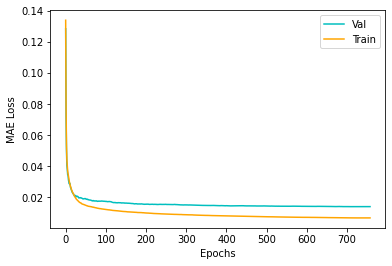

In [ ]:
Min_LR = 0.1 # Minimum learning rate for the XGBoost algorithm
Max_LR = 0.8 # Maximum learning rate for the XGBoost algorithm
Min_Dep = 2 # Minimum max depth for the XGBoost algorithm
Max_Dep = 10 # Maximum max depth for the XGBoost algorithm
n_iter = 50 # Number of iterations for the bayesian optimization model

# Import dataset
X_train, y_train, X_val, y_val = Import_Dataset(saveFits)

# Make a dictionary of parameters we should optimize for the ML algorithm
parameters_BayesianOptimization = {"learning_rate": (Min_LR, Max_LR), #0.1 is default - Boosting learning rate
                                   "max_depth": (Min_Dep, Max_Dep)}  #3 is default - Maximum tree depth for base learners.

# Finding the best parameters for the ML model
BayesianOptimization_func = optimize_DecisionTree(X_train, y_train, parameters_BayesianOptimization, n_iter=n_iter)
print("Best parameters were: ", BayesianOptimization_func.max)


# Get best parameters for the ML model and make max depth to an integer
params = BayesianOptimization_func.max['params']
params['max_depth'] = int(params['max_depth'])

#  Define model, train and validate the model and save model
model, store = train_w_earlyStop(X_train, y_train, n_jobs=1, seed=0, base_score=0.5, n_estimators=100, gamma=0, min_child_weight=1, early_stop=50, **params)
Validate_XGBoost(model, X_val, y_val)
model.save_model(StemName + "_XGB_model.dat")


# Step 4: Calculate atom contribution values



Atom 1  AtomContributionValue:  -0.01699457596987486  +/-  0.002923023730934339 Atom 1  confidence factor:  5.81403968432462
Atom 2  AtomContributionValue:  0.00975168077275157  +/-  0.0030217746733703617 Atom 2  confidence factor:  3.227136973080442
Atom 3  AtomContributionValue:  -0.017684398218989372  +/-  0.003755300817064176 Atom 3  confidence factor:  4.709182853909079
Atom 4  AtomContributionValue:  0.011525524314492941  +/-  0.003638595352413145 Atom 4  confidence factor:  3.1675751761869106
Atom 5  AtomContributionValue:  -0.012401421554386616  +/-  0.002212312323572707 Atom 5  confidence factor:  5.605637785518147
Atom 6  AtomContributionValue:  0.006164898164570332  +/-  0.0021212842503875655 Atom 6  confidence factor:  2.9062103126650682
Atom 7  AtomContributionValue:  -0.014647083356976509  +/-  0.002658000928426119 Atom 7  confidence factor:  5.510563672244268
Atom 8  AtomContributionValue:  0.009898812975734472  +/-  0.0030888339911356627 Atom 8  confidence factor:  3.20

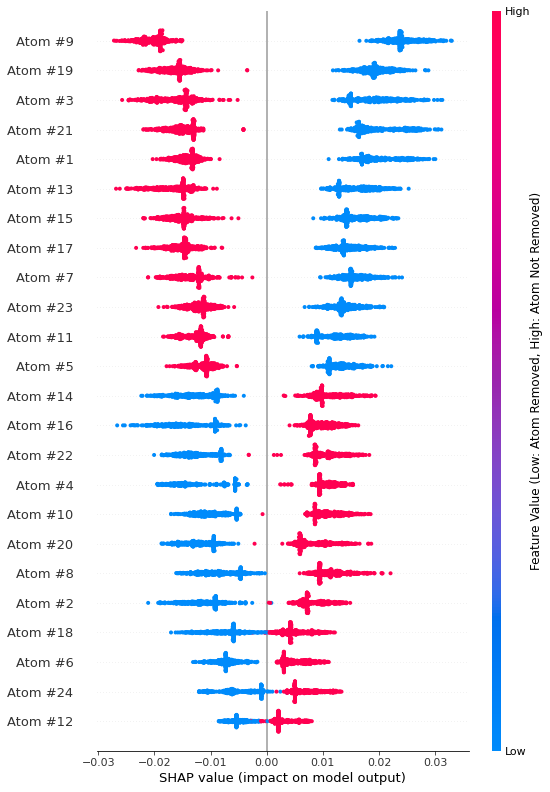

In [ ]:
# Calculate SHAP values and save to savePATH.
explainer, shap_values = shap_essential_figure(model, X_train, "./")

# Calculate atom contribution values
m, AtomContributionValues = calculate_atomContributionValue(shap_values, X_train, "./")

# Output a CrystalMaker and VESTA file
elements, xyz = Load_starting_model(starting_model)
Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, StemName, threshold)
Make_VestaFile(elements, xyz, AtomContributionValues, m, StemName, threshold)


## Download results

In [ ]:
# Download the latest results
files.download(StemName + '_CrystalMaker.cmtx')
#files.download(StemName + '_Vesta.vesta')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Cite
If you use ML-MotEx, please consider citing our paper. Thanks in advance!
```
@article{anker2022ML-MotEx,
title={Extracting Structural Motifs from Pair Distribution Function Data of Nanostructures using Explainable Machine Learning},
author={Andy S. Anker, Emil T. S. Kjær, Mikkel Juelsholt, Troels Lindahl Christiansen, Susanne Linn Skjærvø, Mads Ry Vogel Jørgensen, Innokenty Kantor, Daniel R. Sørensen, Simon J. L. Billinge, Raghavendra Selvan, Kirsten M. Ø. Jensen},
year={2022}}
```

# LICENSE
This project is licensed under the Apache License Version 2.0, January 2004 - see the LICENSE file at https://github.com/AndySAnker/ML-MotEx/blob/main/LICENSE for details.